## Download and unzip datasets

In [1]:
!wget https://www.dropbox.com/s/7swnoebwnuiy20y/unipi_kinematic_AIS_jan_feb2018.zip
!unzip unipi_kinematic_AIS_jan_feb2018.zip

--2021-10-07 18:14:27--  https://www.dropbox.com/s/7swnoebwnuiy20y/unipi_kinematic_AIS_jan_feb2018.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/7swnoebwnuiy20y/unipi_kinematic_AIS_jan_feb2018.zip [following]
--2021-10-07 18:14:27--  https://www.dropbox.com/s/raw/7swnoebwnuiy20y/unipi_kinematic_AIS_jan_feb2018.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucddaf69a9990ae4bee0e102f25b.dl.dropboxusercontent.com/cd/0/inline/BXkj933SxVQAjFtrDwckXExEA75EbIVi9ET3Rzro7RzIspLRlvBNxP7hxChrN-TyEevc9aur6-0qevP5TQXQUub3PbQY8DZbWR62K9s8rz4t5bgisILOVJC0SBloaSbJH9mZa2sm3Ikdoq78ylb7vAND/file# [following]
--2021-10-07 18:14:28--  https://ucddaf69a9990ae4bee0e102f25b.dl.dropboxusercontent.com/cd/0/inline/BXkj933SxVQAjFtrDwckX

## Install GeoPandas

In [2]:
!pip install geopandas

     |████████████████████████████████| 1.0 MB 29.8 MB/s 
     |████████████████████████████████| 15.4 MB 39 kB/s 
     |████████████████████████████████| 6.3 MB 50.6 MB/s 


## Imports

In [3]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np

## Helper Methods

In [9]:
def haversine(p_1, p_2):
	'''
		Return the Haversine Distance of two points in KM
	'''
	lon1, lat1, lon2, lat2 = map(np.deg2rad, [p_1[0], p_1[1], p_2[0], p_2[1]])   
	
	dlon = lon2 - lon1
	dlat = lat2 - lat1    
	a = np.power(np.sin(dlat * 0.5), 2) + np.cos(lat1) * np.cos(lat2) * np.power(np.sin(dlon * 0.5), 2)    
	
	return 2 * 6371.0088 * np.arcsin(np.sqrt(a))

def calculate_acceleration(gdf, spd_column='velocity', ts_column='ts'):
	'''
	Return given dataframe with an extra acceleration column that
	is calculated using the rate of change of velocity over time.
	'''
	# if there is only one point in the trajectory its acceleration will be zero (i.e. constant speed)
	if len(gdf) == 1:
		gdf.loc[:, 'acceleration'] = 0
		return gdf
	
	gdf.loc[:, 'acceleration'] = gdf[spd_column].diff(-1).divide(gdf[ts_column].diff(-1).abs())
	gdf.dropna(subset=['geom'], inplace=True)
	
	return gdf

def calculate_velocity(gdf, spd_column='velocity', ts_column='ts'):
	'''
	Return given dataframe with an extra velocity column that 
	is calculated using the distance covered in a given amount of time.
	TODO - use the get distance method to save some space
	'''
	# if there is only one point in the trajectory its velocity will be the one measured from the speedometer
	if len(gdf) == 1:
		if spd_column is not None:
			gdf.loc[:, 'velocity'] = gdf[spd_column]
		else:
			gdf.loc[:, 'velocity'] = np.nan
		return gdf

	# create columns for current and next location. Drop the last columns that contains the nan value
	gdf.loc[:, 'current_loc'] = gdf.geom.apply(lambda x: (x.x,x.y))
	gdf.loc[:, 'next_loc'] = gdf.geom.shift(-1)
	gdf.loc[:, 'dt'] = gdf[ts_column].diff(-1).abs()
	
	gdf = gdf.iloc[:-1]
	gdf.next_loc = gdf.next_loc.apply(lambda x : (x.x,x.y)) 
		
	# get the distance traveled in n-miles and multiply by the rate given (3600/secs for knots)
	gdf.loc[:,'velocity'] = gdf[['current_loc', 'next_loc']].apply(lambda x : haversine(x[0], x[1])*0.539956803 , axis=1).multiply(3600/gdf.dt)

	gdf.drop(['current_loc', 'next_loc', 'dt'], axis=1, inplace=True)
	gdf.dropna(subset=['geom'], inplace=True)
	
	return gdf

def calculate_angle(point1, point2):
	'''
		Calculating initial bearing between two points
	'''
	lon1, lat1 = point1[0], point1[1]
	lon2, lat2 = point2[0], point2[1]

	dlat = (lat2 - lat1)
	dlon = (lon2 - lon1)
	numerator = np.sin(dlon) * np.cos(lat2)
	denominator = (
		np.cos(lat1) * np.sin(lat2) -
		(np.sin(lat1) * np.cos(lat2) * np.cos(dlon))
	)

	theta = np.arctan2(numerator, denominator)
	theta_deg = (np.degrees(theta) + 360) % 360
	return theta_deg

def calculate_bearing(gdf, course_column='course'):
	'''
	Return given dataframe with an extra bearing column that
	is calculated using the course over ground (in degrees in range [0, 360))
	'''
	# if there is only one point in the trajectory its bearing will be the one measured from the accelerometer
	if len(gdf) == 1:
		if course_column is not None:
			gdf.loc[:, 'bearing'] = gdf[course_column]
		else:
			gdf.loc[:, 'bearing'] = np.nan
		return gdf

	# create columns for current and next location. Drop the last columns that contains the nan value
	gdf.loc[:, 'current_loc'] = gdf.geom.apply(lambda x: (x.x,x.y))
	gdf.loc[:, 'next_loc'] = gdf.geom.shift(-1)
	gdf = gdf.iloc[:-1]
	
	gdf.next_loc = gdf.next_loc.apply(lambda x : (x.x,x.y))
	
	gdf.loc[:,'bearing'] = gdf[['current_loc', 'next_loc']].apply(lambda x: calculate_angle(x[0], x[1]), axis=1)

	gdf.drop(['current_loc', 'next_loc'], axis=1, inplace=True)
	gdf.dropna(subset=['geom'], inplace=True)
	
	return gdf


def cleanse(traj_gdf):
    '''GeoDataFrame cleansing.'''
    
    # Remove duplicate points
    traj_gdf.drop_duplicates(subset=['t', 'mmsi'], inplace=True)

    # Recalculate speed
    traj_gdf['speed'] = traj_gdf.copy().groupby('mmsi', group_keys=False).apply(lambda gdf: calculate_velocity(gdf, spd_column='speed', ts_column='t'))['velocity']

    # Recalculate heading
    traj_gdf['heading'] = traj_gdf.copy().groupby('mmsi', group_keys=False).apply(lambda gdf: calculate_bearing(gdf))['bearing']
    
    # Calculate acceleration
    traj_gdf = traj_gdf.groupby('mmsi', group_keys=False).apply(lambda gdf: calculate_acceleration(gdf, spd_column='speed', ts_column='t'))

    # Drop NaN values
    return traj_gdf.dropna(subset=['speed', 'heading', 'acceleration'])


## Load the dataset

In [5]:
df = pd.read_csv('unipi_kinematic_AIS_jan2018.csv', sep=';')

In [11]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lat, df.lon))

In [15]:
gdf['geom'] = gpd.geoseries.GeoSeries(df.geometry)
gdf = cleanse(gdf)

## Elbow Method

In [16]:
X=np.column_stack((gdf.geom.x, gdf.geom.y))
print(X)

[[37.94741667 23.637135  ]
 [37.94949167 23.56244   ]
 [37.944715   23.64141333]
 ...
 [37.94039833 23.62508167]
 [37.94490167 23.64103667]
 [37.94490667 23.64103833]]


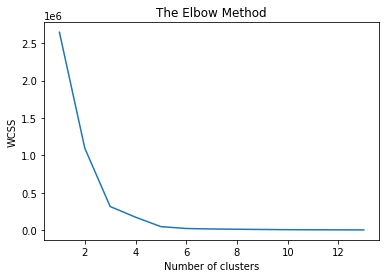

In [17]:
wcss = []
for i in range(1, 14):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 14), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()